# Siamese Network

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
epochs = 10
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [3]:
(x_train_val, y_train_val), (x_test, y_test)= keras.datasets.mnist.load_data()
x_train_val= x_train_val.astype("float32")
x_test = x_test.astype("float32")

11490434/11490434 [==============================] - 1s 0us/step


In [11]:
# Combine train and validation data
x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Keep 50% of train_val in validation set
train_val_size = len(x_train_val)
val_size = int(train_val_size * 0.5)
x_train, x_val = x_train_val[:train_val_size - val_size], x_train_val[train_val_size - val_size:]
y_train, y_val = y_train_val[:train_val_size - val_size], y_train_val[train_val_size - val_size:]

# Make couple pictures

In [12]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

# Split the training pairs

In [14]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

# Split the validation pairs

In [15]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

# Split the test pairs

In [17]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]


# Visualize pairs and their labels

In [18]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """


    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# Inspect training pairs

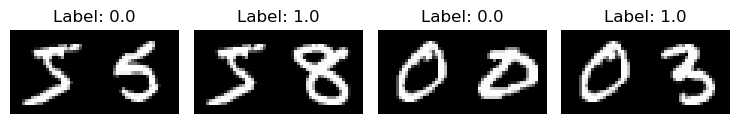

In [19]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

# Inspect validation pairs

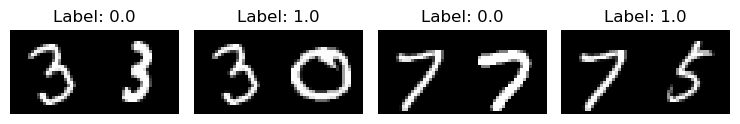

In [20]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

# Inspect test pairs

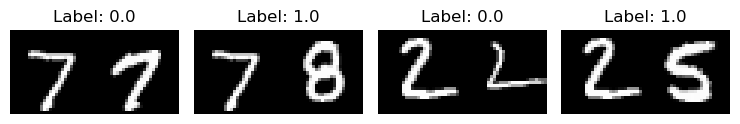

In [21]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

# Pada model ini terdapat dua layer input

In [22]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


# Define the constrastive Loss

In [23]:

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


# Compile the model with the contrastive loss

In [24]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["acuracy"])
siamese.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 10)           5318        ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model_1[0][0]',          

# Train the model

In [25]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

siamese.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = siamese.fit(
    [x_train_1, x_train_2], 
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
    )

Epoch 1/10
1875/1875 [==============================] - 58s 30ms/step - loss: 0.6318 - accuracy: 0.5918 - val_loss: 0.2755 - val_accuracy: 0.9159
Epoch 2/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1632 - accuracy: 0.9454 - val_loss: 0.0836 - val_accuracy: 0.9717
Epoch 3/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.1016 - accuracy: 0.9636 - val_loss: 0.0687 - val_accuracy: 0.9761
Epoch 4/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0856 - accuracy: 0.9709 - val_loss: 0.0648 - val_accuracy: 0.9777
Epoch 5/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0766 - accuracy: 0.9723 - val_loss: 0.0533 - val_accuracy: 0.9822
Epoch 6/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0679 - accuracy: 0.9765 - val_loss: 0.0572 - val_accuracy: 0.9805
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0660 - accuracy: 0.9766 - val_loss: 0.0534 -

# Visualize results

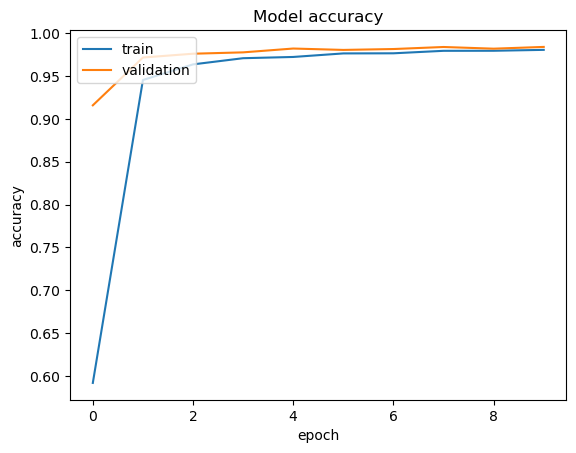

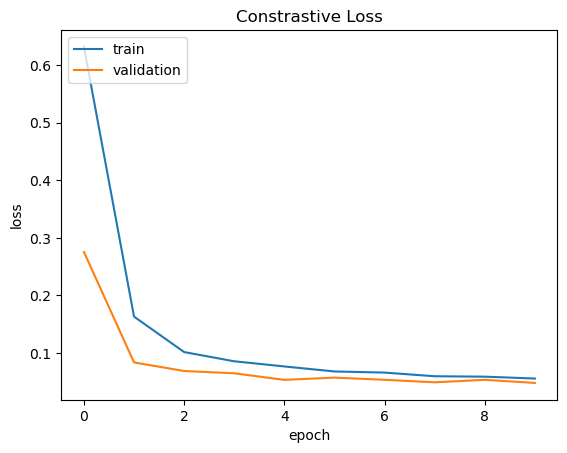

In [26]:

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

# Evaluate the model

In [28]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

625/625 [==============================] - 4s 7ms/step - loss: 0.0388 - accuracy: 0.9859
test loss, test acc: [0.03876941651105881, 0.9859499931335449]


# Visualize the predictions

625/625 [==============================] - 4s 7ms/step


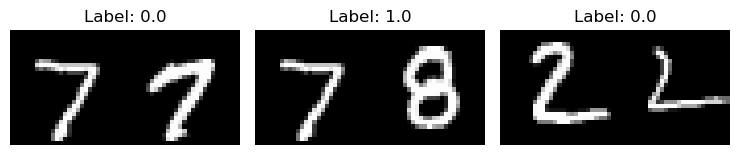

Predictions: [[1.3724480e-05]
 [9.9995393e-01]
 [5.3782517e-04]
 ...
 [9.9215275e-01]
 [4.0301853e-05]
 [9.9760431e-01]]


In [29]:
# prediksi dan visualisasi hasil prediksi
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3)
print("Predictions:", predictions)